In [2]:
import pandas as pd

file_name="dataset_task2.csv"

df=pd.read_csv(file_name)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
duplicates=df.duplicated().sum()
print("Number of duplicated rows: ",duplicates)


Number of duplicated rows:  0


In [4]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols=df.select_dtypes(include=['object']).columns


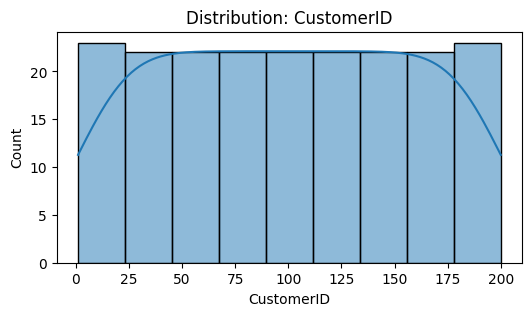

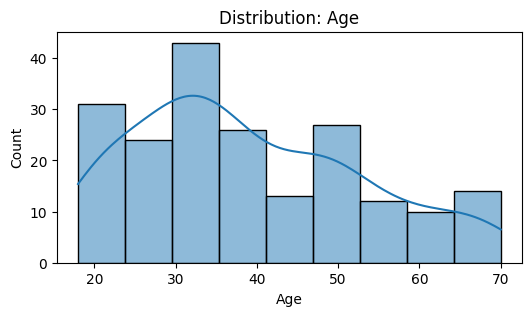

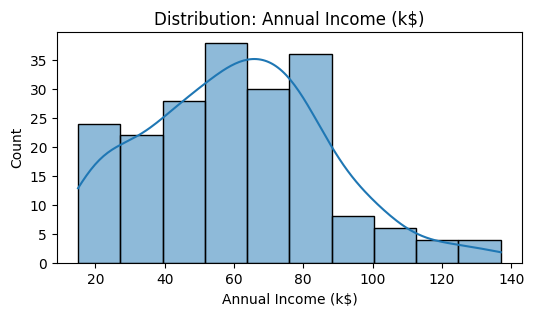

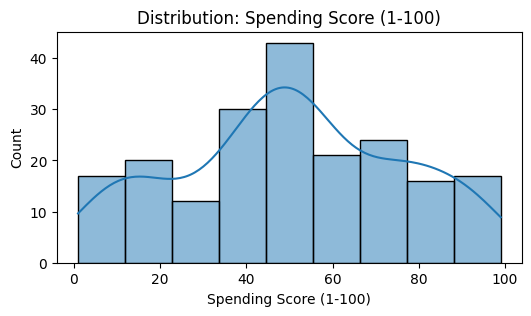

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution: {col}")
    plt.show()

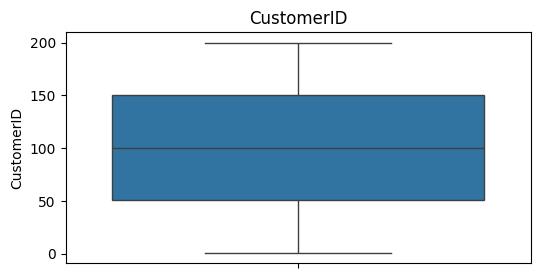

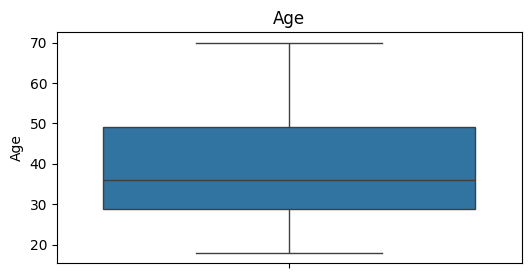

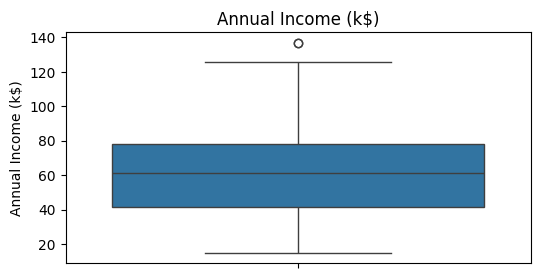

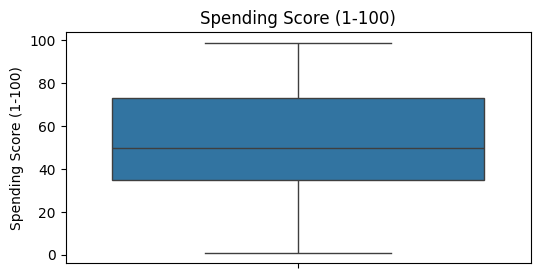

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df[col])
    plt.title(col)
    plt.show()


In [7]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col} has {outliers.shape[0]} outliers")


CustomerID has 0 outliers
Age has 0 outliers
Annual Income (k$) has 2 outliers
Spending Score (1-100) has 0 outliers


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

preprocessor= ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numeric_cols),
        ('cat',OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

X_preprocessed = preprocessor.fit_transform(df)


In [20]:
#PCA
from sklearn.decomposition import PCA
import plotly.express as px

pca_3=PCA(n_components=3,random_state=42)
X_pca3= pca_3.fit_transform(X_preprocessed)

print("Explained variance ratio (3 components):", pca_3.explained_variance_ratio_.sum())
# 3D scatter plot with plotly
fig = px.scatter_3d(x=X_pca3[:,0], y=X_pca3[:,1], z=X_pca3[:,2],color=df['Spending Score (1-100)'],opacity=0.7, title='PCA (3 components) - untargeted',
                 labels={'x':'PC1', 'y':'PC2','z':'PC3'})



fig.show()

#by adding color, a fourth dimension is added, which shows how spending score(an imp column) is influencing the components.. Th egraph shows there is a some correlation as all the yellow dots are on one side and purple on one and pink on one.


Explained variance ratio (3 components): 0.9373220762387224


In [ ]:
# the variance ratio tells us that we have captured about 93.7% of the variance(information) is our three principal components and the data lost is just 6.27%. 
# This shows low domensionality/high correlation.
#PCA shows us that the data is complex and we need to try density-based algorithms like DMSCAN or HDBSCAN in addition to k-means.
#No distinct clusters
#So we need to use elbow and silhouette method to find the best k.

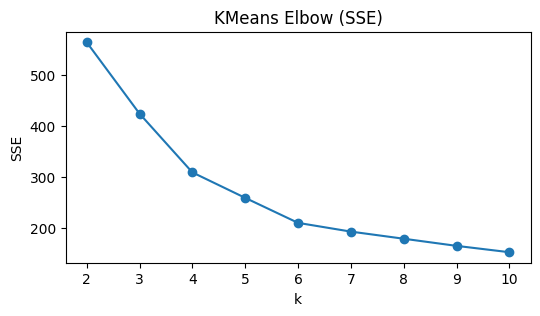

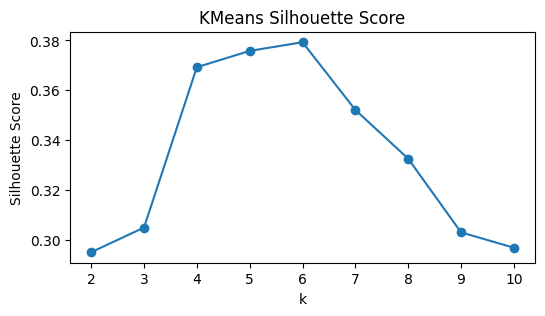

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def kmeans_experiment(X, k_range=range(2,11)):#range is the no. of clusters for which the graph will be produced
    sse = [] #Sum of squared errors/inertia. lower SSE, sloer the data points are to the centroid.  
    silhouettes = []
    models = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10) #ensures robustness by running the algorithm 10 times for different centroids.
        labels = km.fit_predict(X)
        sse.append(km.inertia_)
        silhouettes.append(silhouette_score(X, labels))
        models[k] = (km, labels)
    return sse, silhouettes, models

k_range = range(2,11)
sse, silhouettes, kmodels = kmeans_experiment(X_preprocessed, k_range=k_range)

# Plot elbow
plt.figure(figsize=(6,3))
plt.plot(list(k_range), sse, marker='o') #marker means the circular dots on graph.
plt.title('KMeans Elbow (SSE)')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

# Plot silhouette
plt.figure(figsize=(6,3))
plt.plot(list(k_range), silhouettes, marker='o')
plt.title('KMeans Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import numpy as np

best_k = k_range[np.argmax(silhouettes)] #argmax finds index at maximum silhouette score
best_k, max(silhouettes)
km_best, km_labels = kmodels[best_k]

sil = silhouette_score(X_preprocessed, km_labels)
dbi = davies_bouldin_score(X_preprocessed, km_labels)
ch = calinski_harabasz_score(X_preprocessed, km_labels)
print(f"KMeans (k={best_k}): Silhouette={sil:.4f}, DBI={dbi:.4f}, CH={ch:.4f}")

KMeans (k=6): Silhouette=0.3793, DBI=0.9099, CH=118.6747


In [19]:
# Visualize KMeans clusters on PCA 3D
fig = px.scatter_3d(x=X_pca3[:,0], y=X_pca3[:,1],z=X_pca3[:,2], color=km_labels.astype(str),
                 title=f'KMeans clusters (k={best_k}) projected to PCA (3D)',
                 labels={'x':'PC1','y':'PC2','z':'PC3', 'color':'cluster'})

fig.show()


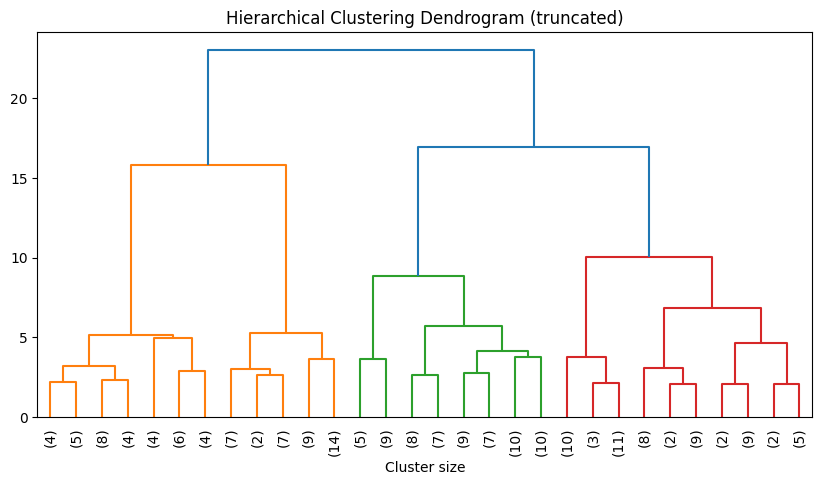

Agglomerative metrics: 0.36487294361658884 1.0302829551152048 109.52236041935463


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

sample_for_dend = X_preprocessed
if X_preprocessed.shape[0] > 2000:
    idx = np.random.RandomState(42).choice(range(X_preprocessed.shape[0]), size=2000, replace=False)
    sample_for_dend = X_preprocessed[idx]

Z = linkage(sample_for_dend, method='ward')  # 'ward' for Euclidean
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster size')
plt.show()

# If we decide number of clusters (say h_k), run AgglomerativeClustering
h_k = 4  # often choose similar to KMeans or from dendrogram, here k=4 is chosen from dendrogram
agg = AgglomerativeClustering(n_clusters=h_k)
h_labels = agg.fit_predict(X_preprocessed)
print("Agglomerative metrics:",
      silhouette_score(X_preprocessed, h_labels),
      davies_bouldin_score(X_preprocessed, h_labels),
      calinski_harabasz_score(X_preprocessed, h_labels))

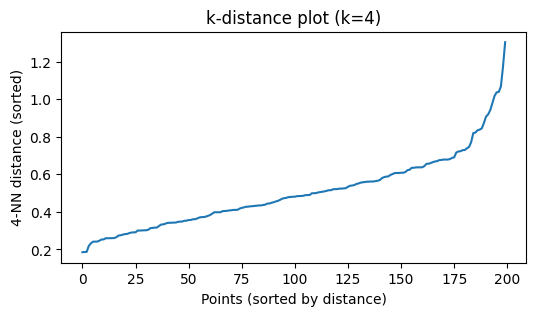

DBSCAN eps=0.3: produced single cluster or all noise
DBSCAN eps=0.35: produced single cluster or all noise
DBSCAN eps=0.4: clusters=2, silhouette=-0.2850660861141156, dbi=2.260166730464119, ch=1.981220954645467
DBSCAN eps=0.45: clusters=4, silhouette=-0.23511884281061665, dbi=1.8069289446507972, ch=5.672867505461352


In [ ]:
# DBSCAN clustering
# Build k-distance plot to pick eps. Use k = min_samples - 1 (commonly min_samples = 4 or dim+1).
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def plot_k_distance(X, k=4):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    # distances to k-th nearest neighbor
    k_dist = np.sort(distances[:, k-1])
    plt.figure(figsize=(6,3))
    plt.plot(k_dist)
    plt.ylabel(f'{k}-NN distance (sorted)')
    plt.xlabel('Points (sorted by distance)')
    plt.title(f'k-distance plot (k={k})')
    plt.show()
    return k_dist

# we may use PCA reduced data for speed when computing k-distance
k_dist = plot_k_distance(X_pca3, k=4)  # using PCA 2D for intuition

# Choose an eps from the "knee" of the plot
# Example: try eps candidate list
eps_candidates = [0.3, 0.35, 0.4, 0.45]  # adjust based on k-distance plot scale
for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_preprocessed)
    # count clusters (exclude noise label -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if len(set(labels)) > 1:
        try:
            sil = silhouette_score(X_preprocessed, labels)
            dbi = davies_bouldin_score(X_preprocessed, labels)
            ch = calinski_harabasz_score(X_preprocessed, labels)
        except:
            sil = np.nan
        print(f"DBSCAN eps={eps}: clusters={n_clusters}, silhouette={sil}, dbi={dbi}, ch={ch}")
    else:
        print(f"DBSCAN eps={eps}: produced single cluster or all noise")


In [ ]:
#DBSCAN failing so go for HDBSCAN

In [37]:
#HDBSCAN
import hdbscan
from hdbscan import HDBSCAN


best_hdb = None
best_score = -np.inf
for min_cs in [5, 10, 20, 30]:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cs)
    labels = clusterer.fit_predict(X_preprocessed)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # HDBSCAN provides cluster_persistence_
    try:
        # Use number of clusters & mean persistence as a heuristic
        persistence = np.mean(clusterer.cluster_persistence_) if len(clusterer.cluster_persistence_)>0 else 0
    except:
        persistence = 0
    print(f"HDBSCAN min_cluster_size={min_cs}: clusters={n_clusters}, mean_persistence={persistence}")
    # You can pick the model with highest persistence or that maximizes silhouette on non-noise points
    if n_clusters > 0:
        try:
            mask = labels != -1
            sil = silhouette_score(X_preprocessed[mask], labels[mask]) if mask.sum()>1 else -1
        except:
            sil = -1
        if sil > best_score:
            best_score = sil
            best_hdb = (min_cs, clusterer, labels, sil)
print("Best HDBSCAN (heuristic) ->", best_hdb[0] if best_hdb else None, best_score)

if best_hdb:
    # Retrieve labels from the best model found
    best_labels = best_hdb[2]
    
    # Filter data and labels to exclude noise points (-1)
    mask = best_labels != -1
    X_filtered = X_preprocessed[mask]
    labels_filtered = best_labels[mask]
    
    # Calculate all three final metrics
    sil = silhouette_score(X_filtered, labels_filtered)
    dbi = davies_bouldin_score(X_filtered, labels_filtered)
    ch = calinski_harabasz_score(X_filtered, labels_filtered)

    # Print the final results for the comparison table
    print("---------------------------------------")
    print(f"FINAL METRICS (min_cs={best_hdb[0]}, Clusters={len(np.unique(labels_filtered))})")
    print(f"  Silhouette Score (Higher is better): {sil:.4f}")
    print(f"  Davies-Bouldin Index (DBI) (Lower is better): {dbi:.4f}")
    print(f"  Calinski-Harabasz (CH) Score (Higher is better): {ch:.4f}")
    print("---------------------------------------")

#to remove warnings
import warnings
# Temporarily ignore all warnings for this block
warnings.filterwarnings('ignore') 

# Your HDBSCAN code block starts here...
import hdbscan
# ... (rest of the code)

# At the end of the block, you can reset the warnings if needed:
# warnings.filterwarnings('default')

HDBSCAN min_cluster_size=5: clusters=6, mean_persistence=0.07136477170364794
HDBSCAN min_cluster_size=10: clusters=3, mean_persistence=0.07406170914756875
HDBSCAN min_cluster_size=20: clusters=0, mean_persistence=0
HDBSCAN min_cluster_size=30: clusters=0, mean_persistence=0
Best HDBSCAN (heuristic) -> 10 0.41717364261381035
---------------------------------------
FINAL METRICS (min_cs=10, Clusters=3)
  Silhouette Score (Higher is better): 0.4172
  Davies-Bouldin Index (DBI) (Lower is better): 0.8381
  Calinski-Harabasz (CH) Score (Higher is better): 53.7829
---------------------------------------


In [39]:

# Collect metrics for all experiments

results = []

# KMeans result
labels_km = km_labels
results.append({
    'method': f'KMeans_k={best_k}',
    'n_clusters': len(set(labels_km)),
    'silhouette': silhouette_score(X_preprocessed, labels_km),
    'dbi': davies_bouldin_score(X_preprocessed, labels_km),
    'ch': calinski_harabasz_score(X_preprocessed, labels_km)
})

# Agglomerative result
labels_agg = h_labels
results.append({
    'method': f'Agglomerative_k={h_k}',
    'n_clusters': len(set(labels_agg)),
    'silhouette': silhouette_score(X_preprocessed, labels_agg),
    'dbi': davies_bouldin_score(X_preprocessed, labels_agg),
    'ch': calinski_harabasz_score(X_preprocessed, labels_agg)
})

# DBSCAN example (if at least one clustered)
# pick the best from earlier eps candidates heuristically (first valid)
for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=5)
    labels_db = db.fit_predict(X_preprocessed)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    if n_clusters > 0:
        try:
            sil = silhouette_score(X_preprocessed, labels_db)
            dbi_val = davies_bouldin_score(X_preprocessed, labels_db)
            ch_val = calinski_harabasz_score(X_preprocessed, labels_db)
        except Exception:
            sil = np.nan; dbi_val = np.nan; ch_val = np.nan
        results.append({
            'method': f'DBSCAN_eps={eps}',
            'n_clusters': n_clusters,
            'silhouette': sil,
            'dbi': dbi_val,
            'ch': ch_val
        })
        break

# HDBSCAN (if available & found)
if best_hdb is not None:
    _, clusterer, labels_hdb, sil_hdb = best_hdb
    n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
    results.append({
        'method': f'HDBSCAN_mincs={best_hdb[0]}',
        'n_clusters': n_clusters,
        'silhouette': sil_hdb,
        'dbi': dbi,
        'ch': ch
    })

results_df = pd.DataFrame(results)
print(results_df)


              method  n_clusters  silhouette       dbi          ch
0         KMeans_k=6           6    0.379297  0.909893  118.674741
1  Agglomerative_k=4           4    0.364873  1.030283  109.522360
2    DBSCAN_eps=0.35           1   -0.097022  1.408020    2.794501
3   HDBSCAN_mincs=10           3    0.417174  0.838078   53.782863


In [ ]:
#HDBSCAN_mincs=10 means minimum cluster size is 10.

Numeric summary (mean/median) per cluster:


cluster                                0          1           2           3  \
CustomerID             mean    82.022727  23.041667  162.000000  164.428571   
                       median  80.500000  23.000000  162.000000  165.000000   
Age                    mean    56.340909  25.250000   32.692308   41.685714   
                       median  54.000000  23.500000   32.000000   43.000000   
Annual Income (k$)     mean    53.704545  25.833333   86.538462   88.228571   
                       median  54.000000  24.500000   79.000000   85.000000   
Spending Score (1-100) mean    49.386364  76.916667   82.128205   17.285714   
                       median  49.000000  76.500000   83.000000   16.000000   

cluster                                4          5  
CustomerID             mean    91.297297  23.190476  
                       median  94.000000  23.000000  
Age                    mean    26.891892  45.523810  
                       median  26.000000  46.000000  
Annual Income (k$)     mean    57.135135  26.285714  
                       median  60.000000  25.000000  
Spending Score (1-100) mean    48.810811  19.380952  
                       median  50.000000  15.000000

Categorical modes per cluster:


,Gender
cluster,
0,Female
1,Female
2,Female
3,Male
4,Female
5,Female


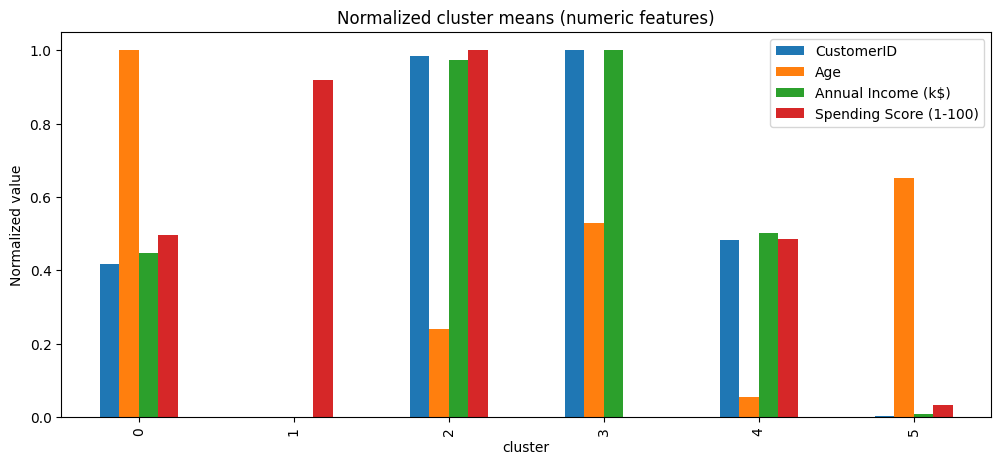

In [41]:
# -----------------------------
# 11) Cluster profiling for best model (example using KMeans best_k)
# -----------------------------
# Choose 'best' model based on metrics from results_df.
# Here we pick the KMeans with best silhouette for demo; replace this logic as you prefer.

chosen_labels = labels_km  # replace if you pick different model

df_profile = df.copy()
df_profile['cluster'] = chosen_labels

# For numeric features: compute mean & median per cluster
numeric_summary = df_profile.groupby('cluster')[numeric_cols].agg(['mean','median']).T
print("Numeric summary (mean/median) per cluster:")
display(numeric_summary)

# For categorical features: mode per cluster
cat_summary = {}
for c in categorical_cols:
    modes = df_profile.groupby('cluster')[c].agg(lambda x: x.mode().iloc[0] if len(x.dropna())>0 else np.nan)
    cat_summary[c] = modes
cat_summary_df = pd.DataFrame(cat_summary)
print("Categorical modes per cluster:")
display(cat_summary_df)

# Visualize cluster centers (for numeric only) using radar or bar charts
cluster_centers = df_profile.groupby('cluster')[numeric_cols].mean()
# Normalize for plotting readability
cluster_centers_norm = (cluster_centers - cluster_centers.min()) / (cluster_centers.max() - cluster_centers.min())

cluster_centers_norm.plot(kind='bar', figsize=(12,5))
plt.title('Normalized cluster means (numeric features)')
plt.ylabel('Normalized value')
plt.show()


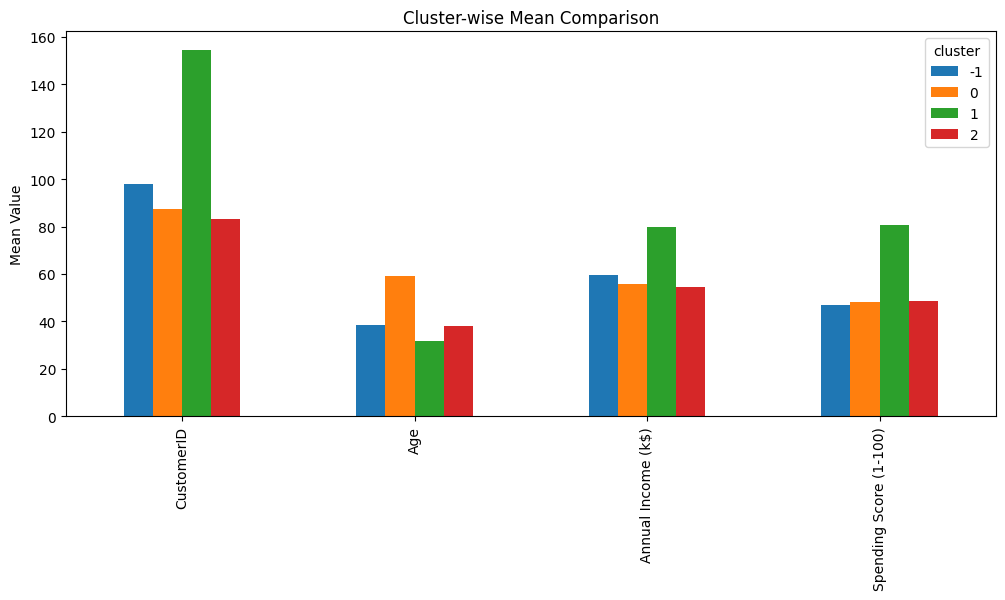

In [42]:
df_profile = df.copy()
df_profile['cluster'] = best_labels   # replace best_labels with your chosen model's labels

# For numeric features → mean & median
numeric_summary = df_profile.groupby('cluster')[numeric_cols].agg(['mean','median'])

# For categorical features → mode
cat_summary = {}
for col in categorical_cols:
    cat_summary[col] = df_profile.groupby('cluster')[col].agg(lambda x: x.mode().iloc[0] if len(x.dropna())>0 else None)
cat_summary_df = pd.DataFrame(cat_summary)

import matplotlib.pyplot as plt

cluster_centers = df_profile.groupby('cluster')[numeric_cols].mean()
cluster_centers.T.plot(kind='bar', figsize=(12,5))
plt.title("Cluster-wise Mean Comparison")
plt.ylabel("Mean Value")
plt.show()

In [ ]:
# ------------------------------------
# Remove noise / outliers (cluster -1)
# ------------------------------------
df_clean = df_profile[df_profile['cluster'] != -1].copy()

# ------------------------------------
# Exclude Identifier Columns (like CustomerID)
# ------------------------------------
# If 'CustomerID' is in numeric_cols, remove it
numeric_cols = [col for col in numeric_cols if col.lower() not in ["customerid", "id", "user_id"]]

# ------------------------------------
# For numeric features → mean & median
# ------------------------------------
numeric_summary = df_clean.groupby('cluster')[numeric_cols].agg(['mean', 'median'])

# ------------------------------------
# For categorical features → mode
# ------------------------------------
cat_summary = {}
for col in categorical_cols:
    cat_summary[col] = df_clean.groupby('cluster')[col].agg(lambda x: x.mode().iloc[0] if len(x.dropna()) > 0 else None)
cat_summary_df = pd.DataFrame(cat_summary)

# -------------------------------
# Combine Numeric + Categorical Profiles
# -------------------------------
cluster_summary = numeric_summary.copy()
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]  # Flatten multi-index

for col in cat_summary_df.columns:
    cluster_summary[col + "_mode"] = cat_summary_df[col]

print("\n🔎 Final Cluster Profile Summary (Excluding Noise & CustomerID):")
print(cluster_summary)


def generate_persona(row):
    
    income = row.get('Annual Income (k$)_mean', None)
    age = row.get('Age_mean', None)
    gender = row.get('Gender_mode', None)

    title = []

    if income is not None:
        if income > cluster_summary['Annual Income (k$)_mean'].mean():
            title.append("High Earners")
        else:
            title.append("Budget Conscious")

    if age is not None:
        if age < cluster_summary['Age_mean'].mean():
            title.append("Young")
        else:
            title.append("Mature")

    if gender is not None:
        title.append(gender)

    return " ".join(title) if title else "Undefined Persona"

cluster_summary['Persona'] = cluster_summary.apply(generate_persona, axis=1)

print("\n✨ Generated Cluster Personas (Excluding -1 & CustomerID):")
print(cluster_summary[['Persona']])


#-1 cluster means the data points that the alogirthm fails to assign to a proper cluster(noise/outliers)


🔎 Final Cluster Profile Summary (Excluding Noise & CustomerID):
          Age_mean  Age_median  Annual Income (k$)_mean  \
cluster                                                   
0        59.100000        61.0                56.000000   
1        31.944444        31.0                79.833333   
2        38.269231        41.5                54.615385   

         Annual Income (k$)_median  Spending Score (1-100)_mean  \
cluster                                                           
0                             54.0                    48.200000   
1                             78.0                    80.500000   
2                             55.5                    48.653846   

         Spending Score (1-100)_median Gender_mode  
cluster                                             
0                                 48.5        Male  
1                                 80.5      Female  
2                                 48.5      Female  

✨ Generated Cluster Personas (Excludi